# 개인 프로젝트 예시


## OPEN API를 활용한 네이버 뉴스 텍스트 분석
- 1. 네이버 오픈 API로 기사 URL 크롤링
- 2. bs4 + selenium으로 기사 제목 및 내용 크롤링

In [1]:
import os
import sys
import urllib.request
import requests

news_data = []
page_count = 5

client_id = "KJKACCZwmz8QlKStuCTn"
client_secret = "5n9ojiieaU"

encText = urllib.parse.quote("아마존")

for idx in range(page_count):
    # json 결과
    url = "https://openapi.naver.com/v1/search/news?query=" + encText + "&start=" + str(idx * 10 + 1)
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if(rescode==200):
    #    response_body = response.read()
        result = requests.get(response.geturl(),
                              headers={"X-Naver-Client-Id":client_id,
                                       "X-Naver-Client-Secret":client_secret}
                             )
        news_data.append(result.json())
    #    print(response_body.decode('utf-8'))
    else:
        print("Error Code:" + rescode)

### 크롤링한 데이타 살펴보기

- 온라인 json 뷰어 이용하기 : http://jsonviewer.stack.hu/

In [2]:
# print(news_data)
# print(len(news_data))
# print(news_data[0])
# print(news_data[0]['items'])
# print(len(news_data[0]['items']))
# print(news_data[0]['items'][2])
print(news_data[0]['items'][7]['link'])

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=029&aid=0002660491


### 네이버 뉴스 하이퍼링크만 리스트로 저장하기

In [3]:
naver_news_link = []

for page in news_data:
    #print(page)
    page_news_link = []
    
    for item in page['items']:
        #print(item)
        temp_link = item['link']
        #print(temp_link)
        if "naver" in temp_link:
            page_news_link.append(temp_link)
    
    naver_news_link.append(page_news_link)
        

# 사이트 링크만 가져오기
for page in naver_news_link:
    for link in page:
        print(link)

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000683774
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=029&aid=0002660491
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=374&aid=0000237056
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=055&aid=0000880154
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=005&aid=0001419478
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000682995
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021693
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021694
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021690
https://sports.news.naver.com/news.nhn?oid=442&aid=0000131042
https://sports.news.naver.com/news.nhn?oid=442&aid=0000131036
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=052&aid=0001561107
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000682405
ht

### 라이브러리 불러오기

In [4]:
import pandas as pd
import numpy as np
from selenium import webdriver
# 진행바 나오는 패키지
from tqdm import tqdm_notebook
import requests
import pickle
import re
import ast

from bs4 import BeautifulSoup 
from urllib.request import urlopen
import urllib
import time

### 셀레니움을 사용하기 위해 가상 크롬드라이버 다운로드
- 크롬 드라이브 다운로드 : https://chromedriver.chromium.org/downloads

In [6]:
from selenium import webdriver

driver = webdriver.Chrome('./driver/chromedriver')

### 수집한 네이버 뉴스 사이트를 방문하여 뉴스 타이틀과 본문내용 가져오기

In [7]:
naver_news_title = []
naver_news_content = []


for n in tqdm_notebook(range(len(naver_news_link))):
    #print(n)
    news_page_title = []
    news_page_content = []
    
    for idx in tqdm_notebook(range(len(naver_news_link[n]))):        
        
    ########### 긁어온 URL로 접속하기 ############    
        try:
            driver.get(naver_news_link[n][idx])
            print(naver_news_link[n][idx])
            
        except:
            print("Timeout!")
            continue        
        
        try:
            response = driver.page_source
            
        except UnexpectedAlertPresentException:
            driver.switch_to_alert().accept()
            print("게시글이 삭제된 경우입니다.")
            continue
        
        soup = BeautifulSoup(response, "html.parser")
        
        ###### 뉴스 타이틀 긁어오기 ######        
        title = None
        
        try:
            item = soup.find('div', class_="article_info")
            title = item.find('h3', class_="tts_head").get_text()
            #print(title)

        except:
            title = "OUTLINK"
        
        #print(title)
        news_page_title.append(title)
        
        
        ###### 뉴스 본문 긁어오기 ######        
        doc = None
        text = ""
                
        data = soup.find_all("div", {"class" : "_article_body_contents"})
        if data:
            for item in data:

                text = text + str(item.find_all(text=True)).strip()
                text = ast.literal_eval(text)
                doc = ' '.join(text)
   
        else:
            doc = "OUTLINK"
            
        news_page_content.append(doc.replace('\n', ' '))

                
    naver_news_title.append(news_page_title)
    naver_news_content.append(news_page_content)

    time.sleep(2)
    
    
print(naver_news_title[0])
print("==================================")
print(naver_news_content[0])

<ipython-input-7-1b13de154505>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(naver_news_link))):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-7-1b13de154505>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(naver_news_link[n]))):


  0%|          | 0/3 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000683774
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=029&aid=0002660491
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=374&aid=0000237056


  0%|          | 0/2 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=055&aid=0000880154
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=005&aid=0001419478


  0%|          | 0/6 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000682995
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021693
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021694
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021690
https://sports.news.naver.com/news.nhn?oid=442&aid=0000131042
https://sports.news.naver.com/news.nhn?oid=442&aid=0000131036


  0%|          | 0/3 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=052&aid=0001561107
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=366&aid=0000682405
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=008&aid=0004555306


  0%|          | 0/5 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=009&aid=0004761269
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=011&aid=0003881547
https://sports.news.naver.com/news.nhn?oid=356&aid=0000045676
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=105&oid=293&aid=0000033743
https://sports.news.naver.com/news.nhn?oid=439&aid=0000021686
['넥슨·엔씨 ‘연봉 잔치’에 뿔난 게임 유저들…“연봉도 확률형으로 지급하라”', '확산일로 확률형 아이템 논란…넥슨 4월 `메이플스토리 간담회`, 성난 `겜심` 달래나', '[오늘의 키워드] 메이플스토리 확률형 아이템 0% 논란…“1등 없는 로또”']
['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    넥슨·넷마블 800만원, 엔씨소프트 최소 1000만원  ‘확률형 아이템’ 논란은 외면, 이용자 불만 고조 "연봉 인상, 결국 이용자가 부담할 것" 김택진 엔씨소프트 대표. / 엔씨소프트 제공 "연봉도 확률형으로 지급해야 한다." 넥슨과 엔씨소프트 등 국내 주요 게임회사들이 임직원 연봉을 큰 폭으로 올리자 확률형 아이템에 불만을 느끼는 게임 이용자들이 "연봉 인상이 결국 유료 아이템 가격 상승으로 이어지는 것 아니냐"며 이런 비판의 목소리를 내고 있다.  12일 게임업계에 따르면 지난달 1일 넥슨은 전 직원의 연봉을 일괄 800만원 인상한다고 밝힌 후 전날까지 11개 게임업체가 연봉 인상안을 발표했다. 구체적으로 넥슨, 엔씨소프트, 넷마블, 크래프톤, 게임

In [8]:
print(naver_news_title[0])

['넥슨·엔씨 ‘연봉 잔치’에 뿔난 게임 유저들…“연봉도 확률형으로 지급하라”', '확산일로 확률형 아이템 논란…넥슨 4월 `메이플스토리 간담회`, 성난 `겜심` 달래나', '[오늘의 키워드] 메이플스토리 확률형 아이템 0% 논란…“1등 없는 로또”']


In [8]:
print(naver_news_content[0])

['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    [아시아경제 부애리 기자] 넥슨의 인기게임 ‘메이플스토리’가 지난달 확률형 아이템 조작 논란에 휩싸이면서 그간 이용자들 사이에서 쌓여있던 불만이 폭발했다. 이용자들은 게임 아이템에 대한 확률 정보를 투명하게 공개하라며 넥슨 본사에서 ‘트럭시위’를 벌였다. 확률형 아이템을 규제 해달라는 청와대 국민청원까지 올라왔다. 국내 게임사들의 주요 매출원인 확률형 아이템에 대한 이용자들의 반발이 커지면서 17조원 규모에 달하는 국내 게임 시장이 들썩이고 있다. Q.확률형 아이템, 왜 논란인가 A .확률형 아이템은 일종의 ‘뽑기’ 개념으로 이해하면 쉽다. 게임 이용자가 어떤 아이템을 획득하게 될 지 구입 전까지 알 수 없는 상품이다. 복권 당첨 수준의 낮은 확률이 문제가 되면서 이용자에게 과도한 지출을 초래한다는 비판을 받아왔다. 게임사들은 한국게임정책자율기구(GSOK)의 자율규제에 따라 일반 모델인 ‘유료 캡슐형 아이템 확률’을 홈페이지에 공개하고 있다. 하지만 게임 내에는 다양한 버전의 확률형 아이템이 존재한다. 확률형 아이템을 모아서 다시 아이템을 만드는 2중 구조의 확률형 아이템, 무료·유료 아이템 결합 아이템, 유료 강화 확률 등에 대한 정보는 부족한 실정이다. 이용자들은 많게는 수천만원을 투자하는 고가의 아이템에 대한 확률 정보도 모르는 상태로 돈을 써야한다는 사실에 불만을 터뜨리고 있다. Q.어떤 게임에서 문제가 불거졌나 A . 최근 논란이 된 넥슨 메이플스토리의 ‘환생의 불꽃’, 엔씨소프트 리니지2M의 ‘신화무기’ 등이 대표적이다. 환생의 불꽃은 확률형 아이템으로 이를 사용할 경우 이용자는 여러 옵션을 획득해 자신이 가진 장비를 업그레이드 할 수 있다. 이용자는 원하는 옵션이 나올 때까지 ‘환생의 불꽃’을 구매한다. 하지만 ‘환생의 불꽃’의 옵션 등장 확률에 대해 이용자들은

In [9]:
print(len(naver_news_title[0]))
print(len(naver_news_content[0]))

3
3


### 피클형태로 저장

In [10]:
with open("./data/naver_news_title.pk", "wb") as f:
    pickle.dump(naver_news_title, f)
    
with open("./data/naver_news_content.pk", "wb") as f:
    pickle.dump(naver_news_content, f)

-------------------------------
## 형태소 분석기 제작하기
- 1. 사용할 형태소 분석기 불러오기
- 2. 텍스트 전처리 하기
- 3. 형태소 / POS tagging 하기

### 형태소 불러오기

In [13]:
from konlpy.tag import Mecab
# from konlpy.tag import Okt
import re

mecab = Mecab()
# okt = Okt()

# 경고 알림이 뜨면 모두 무시
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 텍스트 전처리

In [17]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='cp949') as f:
        for word in f:
            SW.add(word)            
    return SW

def text_tokenizing(doc):    
    # list comprehension을 풀어서 쓴 코드.1)     
#     tokenized_doc = []
    
#     for word in okt.morphs(doc):
#         if word not in SW and len(word) > 1:
#             tokenized_doc.append(word)
    
#     return tokenized_doc    
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]

In [18]:
text = """5G 이동통신망을 빌려 사용하는 ‘5G 알뜰폰’이 올해 도입되고, 내년부터는 의무화된다.
정부는 알뜰폰 사업자(MNVO)가 통신사(MNO)에 통신망을 빌리는 비용(도매대가)을 지난해보다 큰 폭으로 낮춰, 알뜰폰 요금 인하를 유도하기로 했다. 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다.
과학기술정보통신부는 알뜰폰 활성화 추진대책을 25일 발표했다. 알뜰폰 가입자는 800만명으로 이동통신 시장의 12%를 차지한다. 2011년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다. 하지만 지난해 5월 통신 3사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다.
우선 올해 안에 3개 이상의 5G 알뜰폰이 시장에 나온다. 통신사가 5G망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다. 앞서 LG유플러스는 오는 10월 알뜰폰 사업을 시작하는 KB국민은행에 5G망을 제공한다고 밝힌 바 있다. SK텔레콤와 KT도 특정 제휴사를 선택해 올해 안에 5G 알뜰폰을 내놓기로 했다.
내년부터는 5G 알뜰폰 제공이 의무화된다. 지난 22일자로 종료된 도매제공 의무제도의 유효기간을 2022년 9월22일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면, 관련 고시를 개정해 SK텔레콤의 5G망 도매제공을 의무화하겠다는 것이다.
과기정통부 관계자는 “SK텔레콤이 자사와 계약을 맺은 13개 알뜰폰 사업자에게 5G망을 의무 제공하면, 그 외 31개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 KT와 LG유플러스도 5G망을 제공하게 될 것”이라고 내다봤다.
알뜰폰 사업자가 상품을 만드는 방식 크게 2가지다. 하나는 통신사로부터 음성·문자·데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식(종량제 도매제공)이다. 이를 위해 정부는 도매대가 인하율을 음성 17.8%, 데이터 19.2%, 단문메시지 1.15%로, 지난해 음성 15.1%, 데이터 19.1%, 단문메시지 1.13%에 비해 높여 잡았다.
또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서, 그 차액의 범위에서 저렴한 요금제를 내놓는 방식(수익배분 도매제공)이다. 정부는 SK텔레콤의 준보편 요금제인 ‘T플랜 요금제’를 알뜰폰 사업자가 재판매할 수 있게 했다. 기존에 SK텔레콤이 도매제공했던 ‘밴드데이터 요금제’의 최고구간의 대가도 1.5%포인트 낮췄다.
알뜰폰 업계는 대체로 반기는 분위기지만, 알뜰폰 시장을 살릴 수 있을지에는 의구심을 갖고 있다. 업계 관계자는 “도매대가 인하율이 크고, 5G망을 제공하는 것은 긍정적”이라면서도 “수익배분 도매제공의 의무화, 설비를 가진 업체에 대한 접속료 정산 도입 등의 제도적 개선이 필요하다”고 말했다."""

In [19]:
SW = define_stopwords("./data/stopwords-ko.txt")

cleaned_text = text_cleaning(text)
print("전처리 결과 : ", cleaned_text)

tokenized_text = text_tokenizing(cleaned_text)
print("\n형태소 분석 결과 : ", tokenized_text)

전처리 결과 :   이동통신망을 빌려 사용하는  알뜰폰이 올해 도입되고 내년부터는 의무화된다정부는 알뜰폰 사업자가 통신사에 통신망을 빌리는 비용도매대가을 지난해보다 큰 폭으로 낮춰 알뜰폰 요금 인하를 유도하기로 했다 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다과학기술정보통신부는 알뜰폰 활성화 추진대책을 일 발표했다 알뜰폰 가입자는 만명으로 이동통신 시장의 를 차지한다 년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다 하지만 지난해 월 통신 사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다우선 올해 안에 개 이상의  알뜰폰이 시장에 나온다 통신사가 망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다 앞서 유플러스는 오는 월 알뜰폰 사업을 시작하는 국민은행에 망을 제공한다고 밝힌 바 있다 텔레콤와 도 특정 제휴사를 선택해 올해 안에  알뜰폰을 내놓기로 했다내년부터는  알뜰폰 제공이 의무화된다 지난 일자로 종료된 도매제공 의무제도의 유효기간을 년 월일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면 관련 고시를 개정해 텔레콤의 망 도매제공을 의무화하겠다는 것이다과기정통부 관계자는 텔레콤이 자사와 계약을 맺은 개 알뜰폰 사업자에게 망을 의무 제공하면 그 외 개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 와 유플러스도 망을 제공하게 될 것이라고 내다봤다알뜰폰 사업자가 상품을 만드는 방식 크게 가지다 하나는 통신사로부터 음성문자데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식종량제 도매제공이다 이를 위해 정부는 도매대가 인하율을 음성  데이터  단문메시지 로 지난해 음성  데이터  단문메시지 에 비해 높여 잡았다또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서 그 차액의 범위에서 저렴한 요금제를 내놓는 방식수익배분 도매제공이다 정부는 텔레콤의 준보편 요금제인 플랜 요금제를 알뜰폰 사업자가 재판매할 수 있게 했다 기존에 텔레콤이 도매제공했던 

----------------------------
## 피클형태 데이타 읽어와서 빈도 챠트와 워드 클라우드 그리기

### 데이타 전처리와 데이타 불러오기 함수

In [20]:
from tqdm import tqdm_notebook # progress bar
from konlpy.tag import Mecab
# from konlpy.tag import Okt #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [21]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    
    corpus = []
    
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
        
    for page in temp_corpus:
        corpus += page
    
    return corpus

def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='cp949') as f:
        for word in f:
            SW.add(word)            
    return SW


def text_tokenizing(doc):
    return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

In [22]:
input_file_name = "./data/naver_news_content.pk"
documents = read_documents(input_file_name)
documents

하자 운영진은 게임 내 장비 아이템 잠재능력 옵션을 변경하거나 등급을 올릴 수 있는 아이템 \'큐브\'의 획득률을 자율 공개했다. 하지만 이번 확률 공개는 또 다른 논란을 불러왔다. 공개된 자료에 따르면, 큐브에서 \'보스 몬스터 공격 데미지 증가\', \'몬스터 방어율 무시\' 등 일부 잠재능력 옵션은  3개 가운데 최대 2개까지만 설정할 수 있도록 했다고 기술돼 있다.  넥슨은 공지에서 "잠재능력 옵션은 세 개의 옵션 중 최대 두 개까지의 옵션이 재설정된다"며 "일부 잠재능력 옵션이 동시에 여러 개 등장하지 않도록 로직을 설정한 이유는  2011 년 8월 레전드리 잠재능력이 처음 추가될 당시의 보스 사냥이나, 아이템 획득의 밸런스 기준점을 과도하게 초과하는 상황을 방지하려는 목적이었다"고 설명했다. 하지만 유저들은 잠재능력 중복이 2개까지 제한돼 있다는 사실을 수 년 동안 고지받지 못했다고 주장했다. 한 유저는 "로또로 치면 1등 확률을 애초에 0%로 만들어 놓고 판매한 것"이라며 "만약 밸런스 문제 때문에 이를 제거했다면 반드시 사전에 고지했어야 한다"고 문제를 제기했다. 유저들은 확률이 0%인지도 모르고 같은 옵션을 추가하기 위해 유료 아이템 결제에 거액을 쏟아부었다며 허탈하다는 반응이다. 이 가운데 몇몇은 "확률이 0%인 것은 확률이 희박한 것과는 또 다른 문제"라며 법적 대응에 나설 움직임까지 보이고 있다. 논란이 이어지자 지난 9일, 넥슨 강원기 메이플스토리 디렉터는 홈페이지에 사과문을 올리고 "늦었지만 메이플스토리를 아껴 주시는 고객님들과 겸허한 자세로 진솔하게 소통할 수 있는 자리를 준비하고자 한다"며 4월 중 간담회를 열겠다고 발표했다. 강 디렉터는 "해당 자리를 통해 다시 한번 진정성이 담긴 사과를 드리고, 앞으로의 메이플스토리를 위한 허심탄회한 이야기의 장을 마련하겠다"고 전했다. YTN  정윤주 기자 ( younju @ ytnplus.co.kr ) [저작권자(c)  YTN  &  YTN   plus  무단전재 및 재배포 금지]  ▶ 이 

In [24]:
SW = define_stopwords("./data/stopwords-ko.txt")
# SW

In [25]:
cleaned_text = text_cleaning(documents)
cleaned_text

고 있지 않다면서 이용자들이 구입하는 확률형 아이템은 도박의 베팅보다는 아이템을 공정하게 나눠주기 위한 기술적 장치라고 덧붙였다  김택진 엔씨소프트 대표는 지난   년 국회 국정감사에 증인으로 참석했다 조선  당시 국회의원들은 청소년의 결제 상한선을 두는 대책 등을 엔씨소프트 측에 주문하기도 했다 이에 대해 김 대표는 청소년 보호는 어떤 희생을 치르더라도 장치를 마련해야 된다고 본다며 모바일 게임에서 청소년 결제 한도 문제를 적극적으로 검토해봐야 한다고 생각한다고 했다  하지만 년이 지난 현재에도 엔씨소프트가 청소년 보호를 위한 장치를 마련했다는 소식은 들려오지 않는다 회사 관계자는 당시 김택진 대표는 개별 기업이 정책을 정할 수 없기 때문에 국회를 중심으로 업계가 같이 논의해야 한다는 취지로 말한 것이라며 업계의 다양한 사람들이 고민해야 한다고 했다고 밝혔다 이어 모바일 게임은 기본적으로 플랫폼에 대한 논의가 필요하니 구글 플레이스토어나 앱스토어를 통한 논의를 거쳐 청소년 보호 분위기가 조성되면 같이 하겠다는 것이라고 했다   결국 돈수십억 쏟아붓는 린저씨리니지아저씨 있기에  엔씨소프트가 확률형 아이템에 모호한 태도를 취하고 있는 이유로 게임업계는 결국 돈을 꼽는다 엔씨소프트는 지난해 조  억원의 매출을 거뒀고 이 중 리니지가   를 차지한다 또 전체 매출에서 리니지과 리니지   등 모바일 게임은 비중이   에 달한다 이는 전년 대비    늘어난 것이다 실적 성장에 확률형 아이템으로 많은 수익을 얻는 리니지의 기여 정도가 크다는 것을 의미한다 엔씨소프트는 각 게임의 확률형 아이템 매출 비중을 따로 집계하진 않고 있다  게임 플레이 시간이 중요했던 과거   용 리니지 시절에 리니지를 주로 이용하는 린저씨의 의미는 리니지를 장시간 하는 아저씨를 이르는 말이었지만 모바일로 플랫폼이 넘어온 뒤에는 리니지에 돈을 많이 쓰는 아저씨로 바뀌었다  이용자들은 리니지의 상위   위권 캐릭터에 장비 등을 맞추는 비용으로   억원 이상이 쓰였을 것으로 추측하고 있다 또 상위 랭

In [26]:
tokenized_text = text_tokenizing(cleaned_text)

In [27]:
# tokenized_text

### NLTK를 이용한 histogram 분석

In [28]:
import nltk
print(len(tokenized_text))

4985


In [29]:
from pprint import pprint
text = nltk.Text(tokenized_text, name='naver_news')
print(len(set(tokenized_text)))
pprint(text.vocab().most_common(10))

1177
[('아이템', 183),
 ('확률', 182),
 ('게임', 181),
 ('넥슨', 106),
 ('이용자', 81),
 ('메이플', 67),
 ('스토리', 65),
 ('유저', 38),
 ('소프트', 37),
 ('공개', 36)]


### Histogram 그리기

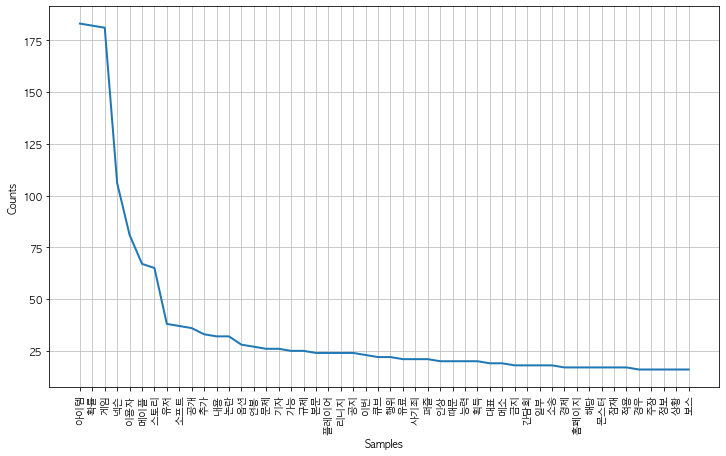

In [30]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(12, 7))
text.plot(50)

### WordCloud 그리기

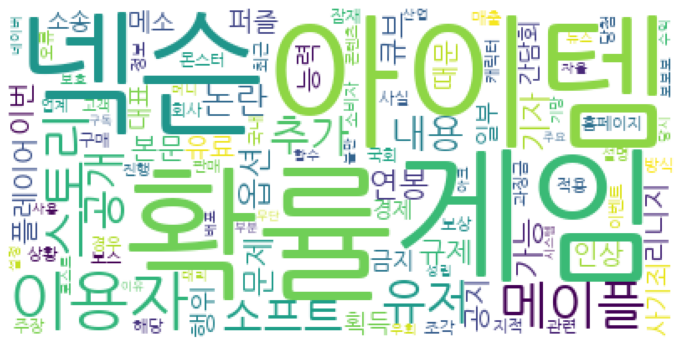

In [32]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

wordcloud = WordCloud(font_path= '/Library/Fonts/NanumGothic.ttf',
    # font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 원하는 이미지를 이용한 워드 클라우드 그리기

In [33]:
from wordcloud import ImageColorGenerator
import numpy as np
from PIL import Image

mask = np.array(Image.open('heart.jpg'))
image_colors = ImageColorGenerator(mask)

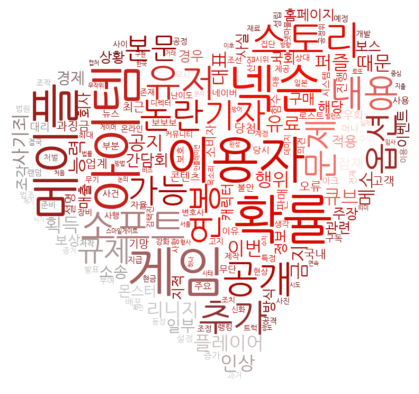

In [36]:
data = text.vocab().most_common(200)

wordcloud = WordCloud(font_path= "/Library/Fonts/NanumGothic.ttf",
    # font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               relative_scaling = 0.1, mask=mask,
               background_color = 'white',
               min_font_size=1,
               max_font_size=100).generate_from_frequencies(dict(data))

default_colors = wordcloud.to_array()

plt.figure(figsize=(10,7))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()